In [1]:
# Core libraries for this tutorial
# Available via `pip install zarr zarr-eosdis-store`
from eosdis_store import EosdisStore
import xarray as xr

# Other Python libraries
import requests
from pqdm.threads import pqdm
from matplotlib import animation, pyplot as plt
from IPython.core.display import display, HTML

# Python standard library imports
from pprint import pprint
import numpy
import cartopy.crs as ccrs
import cartopy

#to make big figures
plt.rcParams['figure.figsize'] = 12, 6

In [2]:
#select SSS L4: 
dataset = 'POCLOUD'
shortname = 'MUR25-JPL-L4-GLOB-v04.2'

#timeframe of interest:
start_date = '2015-08-01T00:00:00Z'
end_date   = '2015-10-31T23:59:59Z'

#region of interest:
lonmin = -170.0
latmin = 65.0
lonmax = -120.0
latmax = 80.0

In [3]:
plt.set_cmap(cmap=plt.get_cmap('turbo'))

<Figure size 864x432 with 0 Axes>

In [4]:
CMR_OPS = 'https://cmr.earthdata.nasa.gov/search'
url = f'{CMR_OPS}/{"collections"}'

In [5]:
provider = 'POCLOUD'
response = requests.get(url,
                        params={
                            'cloud_hosted': 'True',
                            'has_granules': 'True',
                            'provider': provider,
                            'page_size': 251,
                        },
                        headers={
                            'Accept': 'application/json'
                        }
                       )

In [6]:
response.headers['cmr-hits']

'251'

In [7]:
#to find the concept ID and/or shortname
collections = response.json()['feed']['entry']
# for collection in collections:
#     print(f'{collection["archive_center"]} {collection["dataset_id"]} {collection["id"]}')
#OR
# provider = 'POCLOUD'
# response = requests.get(url,
#                         params={
#                             'short_name': shortname,
#                             'cloud_hosted': 'True',
#                             'has_granules': 'True',
#                             'provider': provider,
#                             'page_size': 251,
#                         },
#                         headers={
#                             'Accept': 'application/json'
#                         }
#                        )
# collections = response.json()['feed']['entry']
# for collection in collections:
#     print(f'{collection["archive_center"]} {collection["dataset_id"]} {collection["id"]}')
#OR
# This prints only "MUR" related collections/datasets if you don't know the short name
for collection in collections:
    ID = f'{collection["archive_center"]} {collection["short_name"]} {collection["dataset_id"]} {collection["id"]}'
    if "MUR" in ID:
        print(ID)


NASA/JPL/PODAAC MUR-JPL-L4-GLOB-v4.1 GHRSST Level 4 MUR Global Foundation Sea Surface Temperature Analysis (v4.1) C1996881146-POCLOUD
NASA/JPL/PODAAC MUR25-JPL-L4-GLOB-v04.2 GHRSST Level 4 MUR 0.25deg Global Foundation Sea Surface Temperature Analysis (v4.2) C2036880657-POCLOUD


In [8]:
concept_id='C2036880657-POCLOUD' #got from the list above
url = f'{CMR_OPS}/{"granules"}'
spacebox=f'{lonmin},{latmin},{lonmax},{latmax}' #SW lon, SW lat, NE lon, NE lat #no impact because it is a global gridded map
tempbox=f'{start_date},{end_date}'
response = requests.get(url, 
                        params={
                            'concept_id': concept_id,
                            'temporal': tempbox,
                            'bounding_box': spacebox,
                            'page_size': 200,
                            },
                        headers={
                            'Accept': 'application/json'
                            }
                       )
print(response.status_code)
print(response.headers['cmr-hits'])

200
93


In [9]:
granules = response.json()['feed']['entry']
pprint(granules[0])

{'boxes': ['-90 -180 90 180'],
 'browse_flag': False,
 'collection_concept_id': 'C2036880657-POCLOUD',
 'coordinate_system': 'CARTESIAN',
 'data_center': 'POCLOUD',
 'dataset_id': 'GHRSST Level 4 MUR 0.25deg Global Foundation Sea Surface '
               'Temperature Analysis (v4.2)',
 'day_night_flag': 'UNSPECIFIED',
 'granule_size': '1.8121299743652344',
 'id': 'G2041709170-POCLOUD',
 'links': [{'href': 's3://podaac-ops-cumulus-protected/MUR25-JPL-L4-GLOB-v04.2/20150801090000-JPL-L4_GHRSST-SSTfnd-MUR25-GLOB-v02.0-fv04.2.nc',
            'hreflang': 'en-US',
            'rel': 'http://esipfed.org/ns/fedsearch/1.1/s3#',
            'title': 'This link provides direct download access via S3 to the '
                     'granule.'},
           {'href': 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/MUR25-JPL-L4-GLOB-v04.2/20150801090000-JPL-L4_GHRSST-SSTfnd-MUR25-GLOB-v02.0-fv04.2.nc',
            'hreflang': 'en-US',
            'rel': 'http://esipfed.org/ns/fe

In [10]:
#takes the https link not s3
urls = []
for granule in granules:
    for link in granule['links']:
        if link['rel'].endswith('/data#'):
            urls.append(link['href'])
            break
pprint(urls[0])

'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/MUR25-JPL-L4-GLOB-v04.2/20150801090000-JPL-L4_GHRSST-SSTfnd-MUR25-GLOB-v02.0-fv04.2.nc'


In [11]:
response = requests.get(f'{urls[0]}.dmrpp') #could have been requests.head but answer was NO

#we will only read the etadata to do a subset before reading. In the other draft I made, we read (fetch) and then subset, it's less efficient
print('Can we use EosdisZarrStore and XArray to access these files more efficiently?')
print('Yes' if response.ok else 'No')

Can we use EosdisZarrStore and XArray to access these files more efficiently?
Yes


In [12]:
#Set up a function to open all of our URLs as XArrays in parallel
def open_as_zarr_xarray(url):
    return xr.open_zarr(EosdisStore(url), consolidated=False)
datasets = pqdm(urls, open_as_zarr_xarray, n_jobs=30)

SUBMITTING | :   0%|          | 0/93 [00:00<?, ?it/s]

PROCESSING | :   0%|          | 0/93 [00:00<?, ?it/s]

COLLECTING | :   0%|          | 0/93 [00:00<?, ?it/s]

In [13]:
#aggregate all the data 
ds_stacked = xr.concat(datasets, 'time')
ds_stacked

<xarray.Dataset>
Dimensions:           (time: 93, lat: 720, lon: 1440)
Coordinates:
  * lat               (lat) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon               (lon) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * time              (time) datetime64[ns] 2015-08-01T09:00:00 ... 2015-11-0...
Data variables:
    analysed_sst      (time, lat, lon) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    analysis_error    (time, lat, lon) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    mask              (time, lat, lon) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    sst_anomaly       (time, lat, lon) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
Attributes: (12/54)
    Conventions:                CF-1.7, ACDD-1.3
    title:                      Daily 0.25-degree MUR SST, Final product
    summary:                    A low-resolution version of the MUR SST analy...
    keywords:                   Oceans > Ocean Temperature > Sea Surface Temp...
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD) Sc...
    standard_name_vocabulary:   NetCDF Climate and Forecast (CF) Metadata Con...
    ...                         ...
    publisher_name:             GHRSST Project Office
    publisher_url:              https://www.ghrsst.org
    publisher_email:            gpc@ghrsst.org
    file_quality_level:         3
    metadata_link:              http://podaac.jpl.nasa.gov/ws/metadata/datase...
    acknowledgment:             Please acknowledge the use of these data with...

In [14]:
#select a certain region
ds_stacked_sel = ds_stacked.sel(lat=slice(latmin,latmax), lon=slice(lonmin,lonmax))
ds_stacked_sel['analysed_sst'] = ds_stacked_sel.analysed_sst - 273.15
ds_stacked_sel

<xarray.Dataset>
Dimensions:           (time: 93, lat: 60, lon: 200)
Coordinates:
  * lat               (lat) float32 65.12 65.38 65.62 ... 79.38 79.62 79.88
  * lon               (lon) float32 -169.9 -169.6 -169.4 ... -120.4 -120.1
  * time              (time) datetime64[ns] 2015-08-01T09:00:00 ... 2015-11-0...
Data variables:
    analysed_sst      (time, lat, lon) float32 dask.array<chunksize=(1, 60, 200), meta=np.ndarray>
    analysis_error    (time, lat, lon) float32 dask.array<chunksize=(1, 60, 200), meta=np.ndarray>
    mask              (time, lat, lon) float32 dask.array<chunksize=(1, 60, 200), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float32 dask.array<chunksize=(1, 60, 200), meta=np.ndarray>
    sst_anomaly       (time, lat, lon) float32 dask.array<chunksize=(1, 60, 200), meta=np.ndarray>
Attributes: (12/54)
    Conventions:                CF-1.7, ACDD-1.3
    title:                      Daily 0.25-degree MUR SST, Final product
    summary:                    A low-resolution version of the MUR SST analy...
    keywords:                   Oceans > Ocean Temperature > Sea Surface Temp...
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD) Sc...
    standard_name_vocabulary:   NetCDF Climate and Forecast (CF) Metadata Con...
    ...                         ...
    publisher_name:             GHRSST Project Office
    publisher_url:              https://www.ghrsst.org
    publisher_email:            gpc@ghrsst.org
    file_quality_level:         3
    metadata_link:              http://podaac.jpl.nasa.gov/ws/metadata/datase...
    acknowledgment:             Please acknowledge the use of these data with...

In [15]:
#finally load the data but not necessary as any operation will load the data automatically
# ds_stacked_sel.load()

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


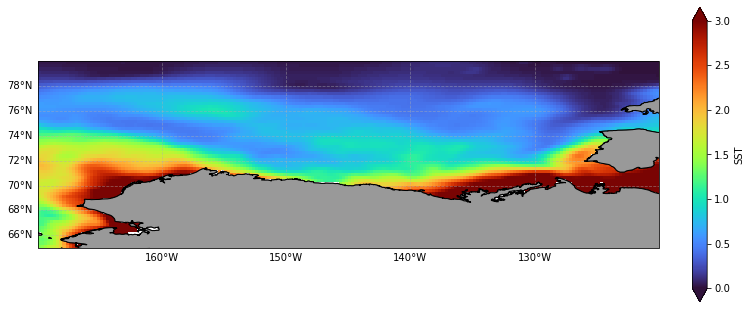

In [16]:
[LO,LA]=numpy.meshgrid(ds_stacked_sel.lon,ds_stacked_sel.lat)
fig = plt.figure()
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude=-150))  # Orthographic
extent = [lonmin, lonmax, latmin, latmax]
ax.set_extent(extent, crs=ccrs.PlateCarree())
plt.set_cmap(cmap=plt.get_cmap('turbo'))
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax.coastlines()
ax.add_feature(cartopy.feature.LAND, zorder=3, facecolor=[.6,.6,.6], edgecolor='black')
cs = ax.pcolormesh(LO,LA,ds_stacked_sel.analysed_sst.std(dim='time'),vmin=0,vmax=3,transform=ccrs.PlateCarree(),shading='auto')
cb = plt.colorbar(cs,fraction = 0.022,extend='both')
cb.set_label('SST',fontsize = 10)

In [17]:
#for the animation, you need a dataset without infinite values
def show_time_step(i):
    plt.clf()
    res = ds_stacked_sel.analysed_sst[i].plot.imshow(vmin=-5, vmax=10, cmap=plt.get_cmap('turbo'))
    return (res,)

In [18]:
# anim = animation.FuncAnimation(plt.gcf(), func=show_time_step, frames=len(ds_stacked_sel.sss))
anim = animation.FuncAnimation(plt.gcf(), func=show_time_step, frames=len(ds_stacked_sel.analysed_sst))
display(HTML(anim.to_jshtml()))
plt.close()